<a href="https://colab.research.google.com/github/georgezoto/TensorFlow-in-Practice/blob/master/C4W4_2_Sunspots_Conv1D_Multi_LSTM_Dense_Lambda_Huber_learning_rate_mae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [0]:
import tensorflow as tf
print(tf.__version__)

2.2.0-rc3


In [0]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [0]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2020-04-26 02:03:40--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 2404:6800:4003:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2020-04-26 02:03:40 (89.5 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



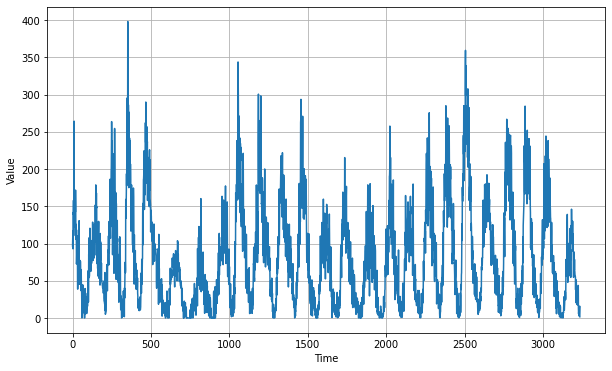

In [0]:
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [0]:
time

array([   0,    1,    2, ..., 3232, 3233, 3234])

In [0]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [0]:
def windowed_dataset_dnn(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [0]:
dataset = windowed_dataset_dnn(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 841
Trainable params: 841
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.fit(dataset,epochs=100,verbose=1)

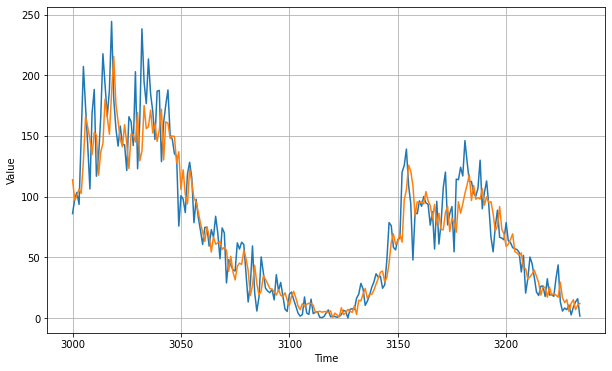

In [0]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [0]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

14.931627

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model.summary()

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
lstm (LSTM)                  (None, None, 64)          24832     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
dense (Dense)                (None, None, 30)          1950      
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           11        
____________________

In [0]:
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
12/12 [==============================] - 0s 28ms/step - loss: 80.0357 - mae: 80.3314 - lr: 1.0000e-08
Epoch 2/100
12/12 [==============================] - 0s 24ms/step - loss: 78.3454 - mae: 78.5918 - lr: 1.1220e-08
Epoch 3/100
12/12 [==============================] - 0s 24ms/step - loss: 75.4876 - mae: 75.9497 - lr: 1.2589e-08
Epoch 4/100
12/12 [==============================] - 0s 25ms/step - loss: 72.5510 - mae: 72.7658 - lr: 1.4125e-08
Epoch 5/100
12/12 [==============================] - 0s 24ms/step - loss: 69.0571 - mae: 69.2672 - lr: 1.5849e-08
Epoch 6/100
12/12 [==============================] - 0s 25ms/step - loss: 65.5337 - mae: 65.6099 - lr: 1.7783e-08
Epoch 7/100
12/12 [==============================] - 0s 25ms/step - loss: 61.4206 - mae: 62.0241 - lr: 1.9953e-08
Epoch 8/100
12/12 [==============================] - 0s 26ms/step - loss: 58.5597 - mae: 58.6369 - lr: 2.2387e-08
Epoch 9/100
12/12 [==============================] - 0s 26ms/step - loss: 55.3287 - mae:

(1e-08, 0.0001, 0.0, 60.0)

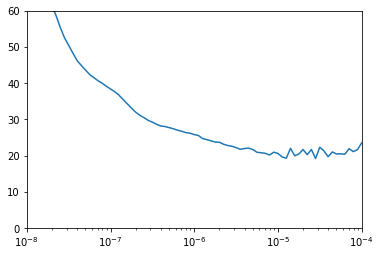

In [0]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 60)          360       
_________________________________________________________________
lstm (LSTM)                  (None, None, 60)          29040     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 60)          29040     
_________________________________________________________________
dense (Dense)                (None, None, 30)          1830      
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           11        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0

In [0]:
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 0s 14ms/step - loss: 38.7193 - mae: 39.4161
Epoch 2/500
30/30 [==============================] - 0s 14ms/step - loss: 25.7432 - mae: 26.2680
Epoch 3/500
30/30 [==============================] - 0s 15ms/step - loss: 22.0644 - mae: 22.5697
Epoch 4/500
30/30 [==============================] - 0s 15ms/step - loss: 20.4653 - mae: 20.9631
Epoch 5/500
30/30 [==============================] - 0s 15ms/step - loss: 19.7753 - mae: 20.2582
Epoch 6/500
30/30 [==============================] - 0s 15ms/step - loss: 19.2806 - mae: 19.7953
Epoch 7/500
30/30 [==============================] - 0s 14ms/step - loss: 18.7091 - mae: 19.2219
Epoch 8/500
30/30 [==============================] - 0s 14ms/step - loss: 18.1375 - mae: 18.6112
Epoch 9/500
30/30 [==============================] - 0s 15ms/step - loss: 18.1595 - mae: 18.6373
Epoch 10/500
30/30 [==============================] - 0s 14ms/step - loss: 18.2913 - mae: 18.7694
Epoch 11/500
30/30 [=========

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

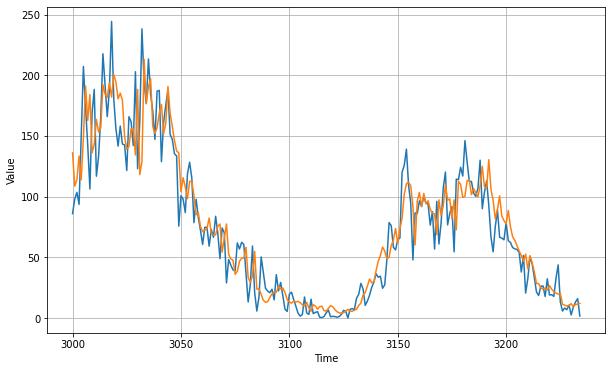

In [0]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [0]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

15.171835

<Figure size 432x288 with 0 Axes>

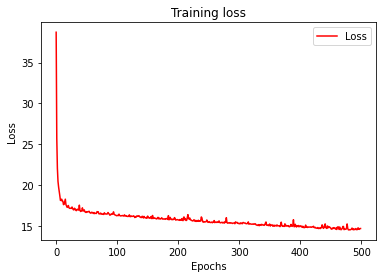

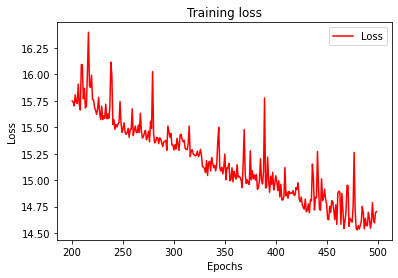

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [0]:
print(rnn_forecast)

[136.03911   108.64892   113.79592   133.36797   113.831924  148.42674
 191.09799   162.74585   184.07158   135.99425   143.39186   163.61166
 153.16757   156.58284   192.20506   184.43596   181.75798   193.83522
 182.03194   200.57831   194.38606   180.50687   185.26776   179.23616
 149.59795   139.1947    141.269     156.01706   156.00826   134.29802
 188.31035   118.134056  128.8166    213.05894   176.83047   190.30713
 197.25131   157.84265   151.94907   156.94774   168.70683   175.99423
 151.96443   160.16432   190.71771   168.78769   157.92017   146.24026
 137.62968   135.99736   104.0437    115.55002   107.93031    98.36869
 112.5301    112.74097   100.526665   85.103836   86.82135    75.43861
  71.117546   72.32012    73.6058     82.30747    69.66299    68.38743
  68.58975    75.52736    77.39562    54.249146   65.90988    77.43268
  52.379192   48.606426   47.71083    35.977863   38.400333   46.68558
  49.27989    49.409748   58.207123   33.355747   29.446606   34.633602
  54.